# Binary Classification | EDA + Logistic Regression 

## Overview

### Goal
The objective of this competition is to predict which customers respond positively to an automobile insurance offer. <br>
목표는 자동차 보험 제안에 어떤 고객이 긍정적으로 반응하는지를 예측하는 것이다.

### Evaluation
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets. <br>
제출된 File은 예측 확률과 실제 Target 값을 사용하여 ROC 곡선 아래 면적(AUC)을 통해 평가된다.

### Submission File
For each id row in the test set, you must predict the probability of the target, Response. The file should contain a header and have the following format. <br>
Test Set의 각 ID 행에 대해 Target(Response)의 확률을 예측해야 한다. 제출 File은 Header를 포함하고 아래와 같은 형식을 갖는다.
```python
id,Response
11504798,0.5
11504799,0.5
11504800,0.5
etc.
```

### Timeline
Start Date - July 1, 2024 <br>
Entry Deadline - Same as the Final Submission Deadline <br>
Team Merger Deadline - Same as the Final Submission Deadline <br>
Final Submission Deadline - July 31, 2024 <br>
All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## Dataset Description

### Features
**Predictors** <br>
- **id** : (int) Lead identification. **ID 번호** <br>
- **Gender** : (string) Male or female. **성별** <br>
- **Age** : (int) Age of lead, in years. **나이** <br>
- **Driving_License** : (int) Binary categorical variable: 1 or 0 for lead has or does not have a driver's license. **운전 면허 / 소지 1, 미소지 0** <br>
- **Region_Code** : (int) Categorical region code. **지역 번호** <br>
- **Previously_Insured** : (int) Binary categorical variable: 1 or 0 for lead has previously had insurance or not. **보험 가입 여부 / 가입 1, 미가입 0** <br>
- **Vehicle_Age** : (string) Categorical variable with 3 possible values which stand for the approx. vehicle age in years. **차 나이, 차 사용 기간 / 3가지 값 중 하나** <br>
- **Vehicle_Damage** : (string) Binary categorical variable: Yes or No if the vehicle was damaged or not. **차량 손상 여부 / 손상 Yes, 미손상 No** <br>
- **Annual_Premium** : (float) Annual premium paid by lead, in USD. **연간 보험료 / Dollar 기준** <br>
- **Policy_Sales_Channel** : (float) Categorical variable that stands for the type of sales channel used. **판매 Channel의 유형을 나타내는 Categorical Variables** <br>
- **Vintage** : (int) **Number of Days**, Customer has been associated with the company. <br>

**Target**
- **Response** : (int) Categorical binary variable: 1 or 0 for lead responded (or turned) or not. **응답 여부 / 응답 1, 미응답 0**

## Import Library and Conifg

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Handling
import numpy as np  # Math Operations
import pandas as pd  # DataFrames
import polars as pl  # DataFrames

# Time
import time  # Print Time for Models

# Visualization Tools
import matplotlib.pyplot as plt  # Figures, Plots, and Visualizations
import seaborn as sns  # Advanced visualizations

# Feature Importance
from sklearn.metrics import mutual_info_score as mi_score  # Mutual Information (Feature Importance)

# General
import re
import os
import random
import tqdm as tqdm

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold  # Split data for model performance measurements and cross-validation
from sklearn.preprocessing import LabelEncoder  # Encode string categorical features into numerical
from imblearn.over_sampling import SMOTE  # Over-sample to handle target class imbalance
from imblearn.under_sampling import RandomUnderSampler  # Under-sample to handle target class imbalance

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression

# Measure Model Performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Data Loading and Setting

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Print filepaths and save to file_dirs 
file_dirs = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_dirs.append(dirname + '/' + filename)
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [3]:
# Load in Train and Test CSV Files as Pandas Data Frames
train = pd.read_csv(file_dirs[1])
test = pd.read_csv(file_dirs[2])

# Exploratory Data Analysis

In [4]:
# DataFrame의 요약 정보를 출력한다. 
# DataFrame의 총 Row, Column의 수 / Data Type / Non-Null의 수 / 각 Column의 Memory 사용량 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [5]:
# DataFrame의 요약 정보를 출력한다. 
# DataFrame의 총 Row, Column의 수 / Data Type / Non-Null의 수 / 각 Column의 Memory 사용량 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7669866 entries, 0 to 7669865
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 643.7+ MB


In [6]:
# 각 Column의 Data Type을 출력한다. 
# Column의 이름과 Data Type
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [7]:
# 각 Column의 Data Type을 출력한다. 
# Column의 이름과 Data Type
test.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
dtype: object

In [8]:
# DataFrame의 Row, Column을 출력한다. 
# (Row 수, Column 수) 형태의 Tuple
print(train.shape)
print(test.shape)

(11504798, 12)
(7669866, 11)


In [9]:
# DataFrame의 상위 5개 Row를 출력한다. 
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [10]:
# DataFrame의 상위 5개 Row를 출력한다. 
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [11]:
# describe()은 수치형 Data로 통계값 추출한다. 
# 범주형 Data의 경우 include = '0'을 추가해 확인할 수 있다. 
'''
count : 갯수
mean : 평균
std : 표준 편차
min : 최소값
25% : 제 1사분위값
50% : 중앙값, 중위값
75% : 제 3사분위값 
max : 최대값
'''
train.describe().astype('int64')

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798,11504798,11504798,11504798,11504798,11504798,11504798,11504798,11504798
mean,5752398,38,0,26,0,30461,112,163,0
std,3321149,14,0,12,0,16454,54,79,0
min,0,20,0,0,0,2630,1,10,0
25%,2876199,24,1,15,0,25277,29,99,0
50%,5752398,36,1,28,0,31824,151,166,0
75%,8628597,49,1,35,1,39451,152,232,0
max,11504797,85,1,52,1,540165,163,299,1


In [12]:
test.describe().astype('int64')

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,7669866,7669866,7669866,7669866,7669866,7669866,7669866,7669866
mean,15339730,38,0,26,0,30465,112,163
std,2214099,14,0,12,0,16445,54,79
min,11504798,20,0,0,0,2630,1,10
25%,13422264,24,1,15,0,25280,29,99
50%,15339730,36,1,28,0,31827,151,166
75%,17257196,49,1,35,1,39460,152,232
max,19174663,85,1,52,1,540165,163,299


## Missing Values

결측치가 없는 Data, 모든 Feature의 모든 행에 값이 존재하는 상태이다. <br>
이 경우 Data Pre-Process 과정에서 결측치 처리를 생략해도 된다. 

In [13]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [14]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

Missing Values:
 Series([], dtype: int64)


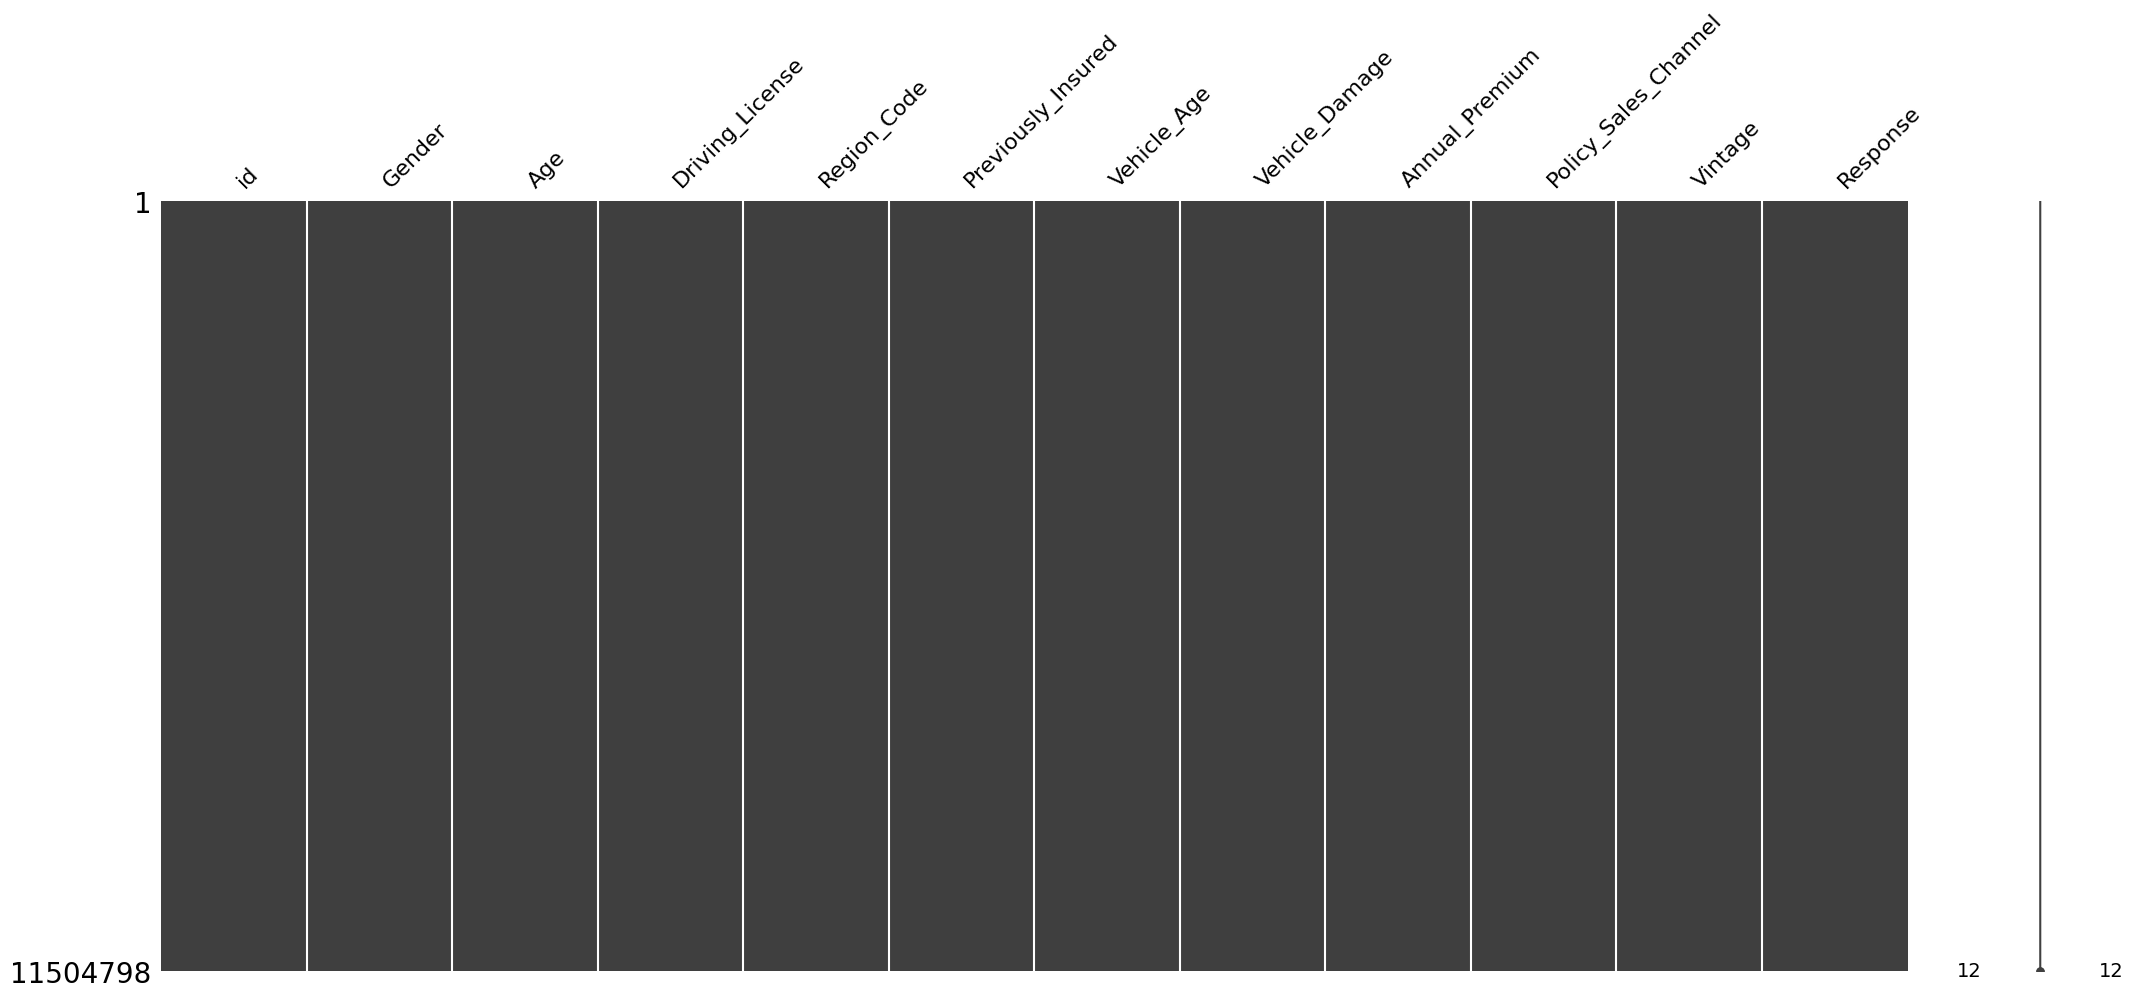

In [15]:
# Check Missing Values
missing_values = train.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Missing Values Visualization
import missingno as msno
msno.matrix(train)
plt.show()

## Target Variables Visualization 

Responese Variable의 분포를 Visualization 해 Class의 불균형을 확인한다. <br>
불균형한 Dataset에서는 Accuracy(정확도)보다는 Percision(정밀도), Recall(재현율), F1 Score, ROC-AUC와 같은 평가 지표를 사용하는 것이 더 적절하다. 

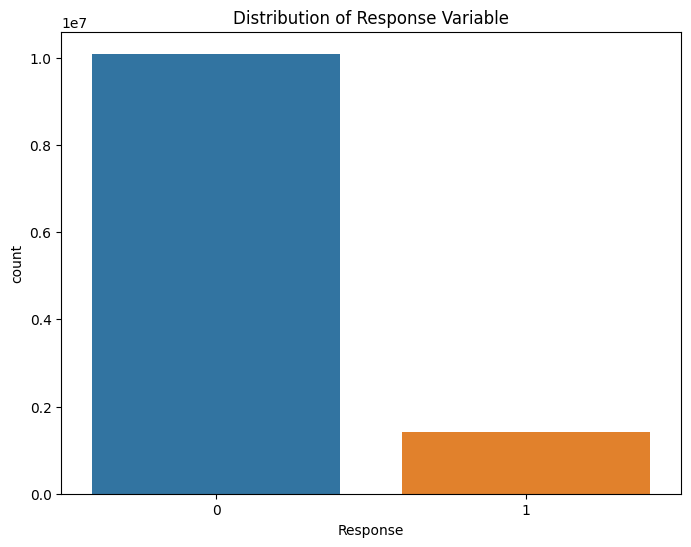

In [16]:
plt.figure(figsize = (8, 6))
sns.countplot(x = train['Response'])
plt.title('Distribution of Response Variable')
plt.show()

## Type of Variables

### Categorical Variables
1. Gender : Male, Female
2. Vehicle_Age
3. Vehicle_Damage : Yes, No
4. Region_Code : 숫자형이지만 Categorical에 속한다. 
5. Policy_Sale_Channel : 숫자형이지만 Categorical에 속한다. 

### Numerical Variables
1. Age : 정수 
2. Driving_License : 1, 0
3. Perviously_Insured : 1, 0
4. Annual_Premium : 실수
5. Vintage : 정수

### Visualize the Distribution of Data
- Categorical Variables : bar
- Numerical Variables
    - Discrete Type : bar
    - Continuous Form : kedplot
- Categorical + Numerical : boxplot, violinplot
- Numerical + Numerical : scatter

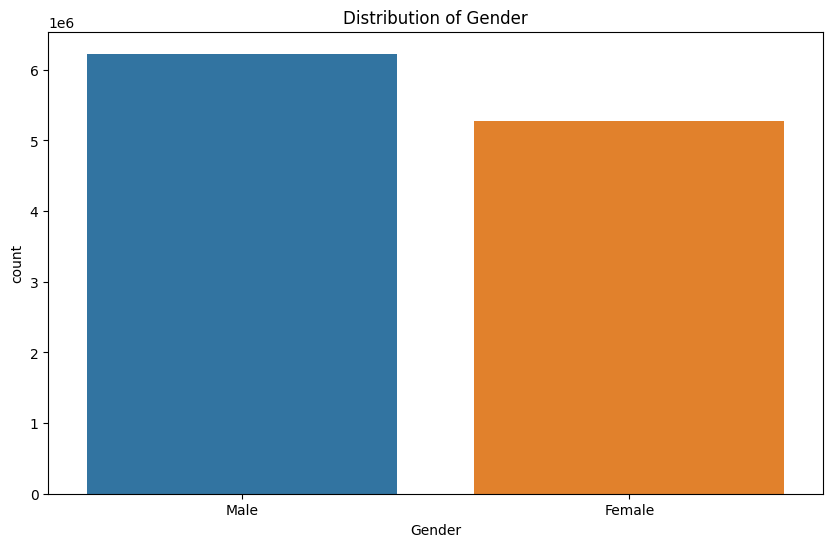

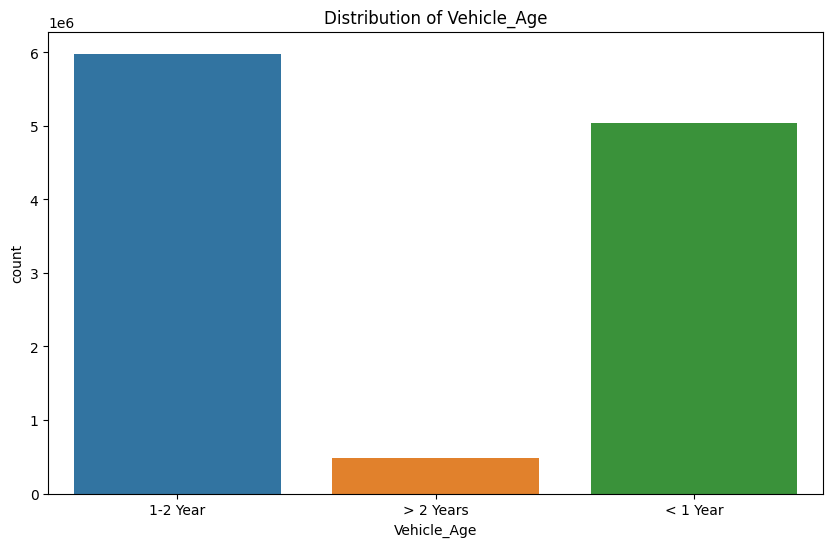

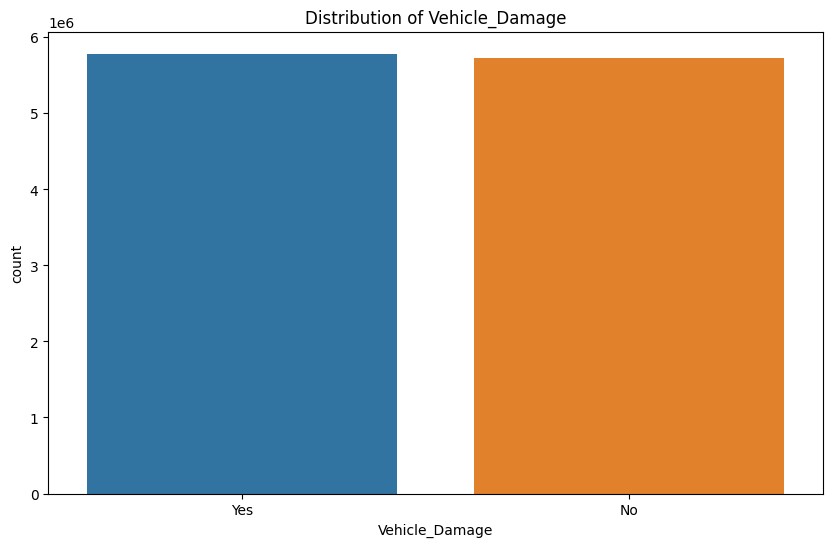

In [17]:
# Visualize Categorical Variables
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
for feature in categorical_features:
    plt.figure(figsize = (10, 6))
    sns.countplot(data = train, x = feature) 
    plt.title(f'Distribution of {feature}')
    plt.show()

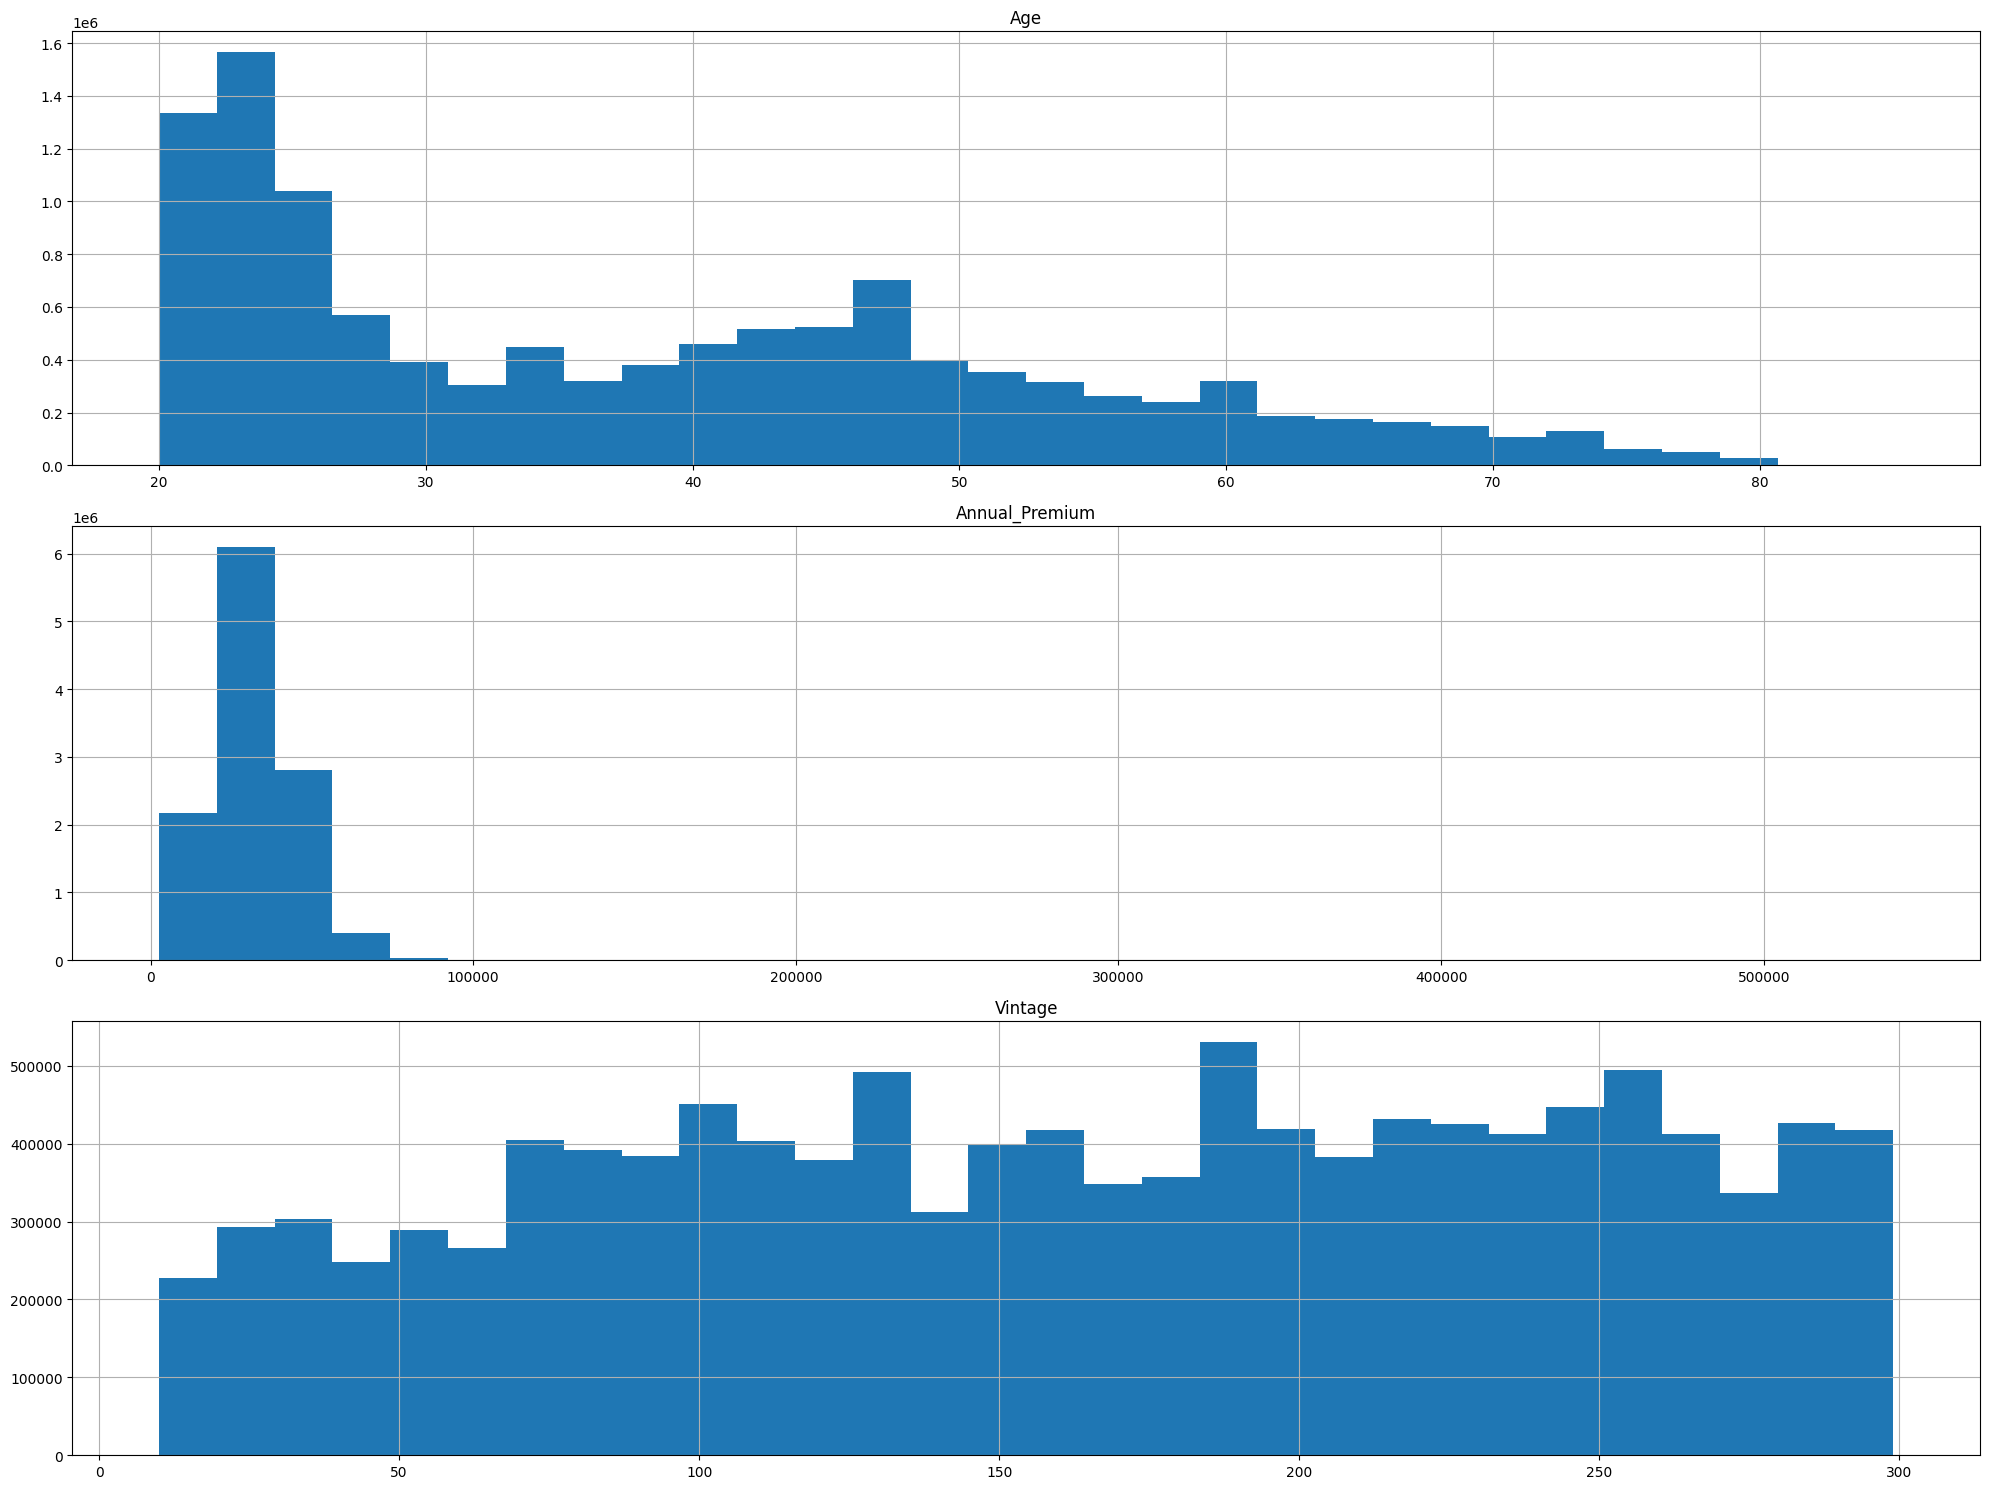

In [18]:
# Visualize Numerical Variables
numerical_features = ['Age', 'Annual_Premium', 'Vintage']
train[numerical_features].hist(bins = 30, figsize = (20, 15), layout = (3, 1))
plt.tight_layout()
plt.show()

Region_Code와 Policy_Sales_Channel은 Categorical이지만 많은 고유값을 가질 수 있다. <br>
이러한 Variables은 단순한 countplot으로 Visualize가 어려우므로 제외한다. <br>
Driving_License와 Previously_Insured는 Binary Variables로 Visualize 중요도가 낮다.

## Converting String Categorical Variables to Int
Gender, Vehicle_Age, Vehicle_Damage 각 Feature의 고유한 문자열 값을 숫자로 변환한다. <br>

**Version 1.** <br>
Gender, Vehicle_Damege = One-Hot Encoding <br>
Vehicle_Age = Label Encoding <br>

순서가 없는 Categorical Variables의 경우 LabelEncoding보다 One-Hot Encoding가 더 적합하다. <br>

**Version 2.** <br>
Gender, Vehicle_Damege, Vehicle_Age = LabelEncoding

In [19]:
# Version 1. LabelEncoder + One-Hot Encoder
# 순서가 없는 Categorical Variables의 경우 LabelEncoding보다 One-Hot Encoding가 더 적합하다. 
# Gender, Vehicle_Damege = One-Hot Encoding
# Vehicle_Age = Label Encoding

'''
# One-Hot Encoding for Gender and Vehicle_Damage
train = pd.get_dummies(train, columns = ['Gender', 'Vehicle_Damage'])
test = pd.get_dummies(test, columns = ['Gender', 'Vehicle_Damage'])

# Label Encoding for Vehicle_Age
le = LabelEncoder()
train['Vehicle_Age'] = le.fit_transform(train['Vehicle_Age'])
test['Vehicle_Age'] = le.fit_transform(test['Vehicle_Age'])

# Remove unnecessary extra index and set the id feature as the index
train.set_index('id', inplace = True)
test.set_index('id', inplace = True)

# Categorical Variables의 고유 범주를 확인한다. 
# 미리 정의된 Categorical Variables List를 사용해 각 Variables의 고유 범주와 갯수를 출력한다. 
categorical_columns = ['Vehicle_Age'] + [col for col in train.columns if col.startswith('Gender_') or col.startswith('Vehicle_Damage_')]

for col in categorical_columns:
    categories = train[col].unique()
    print(f'[{col}] ({len(categories)})')
    print('\n'.join(map(str, categories)))
    print()
'''

"\n# One-Hot Encoding for Gender and Vehicle_Damage\ntrain = pd.get_dummies(train, columns = ['Gender', 'Vehicle_Damage'])\ntest = pd.get_dummies(test, columns = ['Gender', 'Vehicle_Damage'])\n\n# Label Encoding for Vehicle_Age\nle = LabelEncoder()\ntrain['Vehicle_Age'] = le.fit_transform(train['Vehicle_Age'])\ntest['Vehicle_Age'] = le.fit_transform(test['Vehicle_Age'])\n\n# Remove unnecessary extra index and set the id feature as the index\ntrain.set_index('id', inplace = True)\ntest.set_index('id', inplace = True)\n\n# Categorical Variables의 고유 범주를 확인한다. \n# 미리 정의된 Categorical Variables List를 사용해 각 Variables의 고유 범주와 갯수를 출력한다. \ncategorical_columns = ['Vehicle_Age'] + [col for col in train.columns if col.startswith('Gender_') or col.startswith('Vehicle_Damage_')]\n\nfor col in categorical_columns:\n    categories = train[col].unique()\n    print(f'[{col}] ({len(categories)})')\n    print('\n'.join(map(str, categories)))\n    print()\n"

Region_Code와 Policy_Sales_Channel은 Categorical이지만 많은 고유값을 가질 수 있다. <br>
이러한 Variables은 단순한 conuntplot으로 Visualize가 어려우므로 제외한다. <br>
Driving_License와 Previously_Insured는 Binary Variables로 Visualize 중요도가 낮다. 

In [20]:
# Version 2. LabelEncoder
# Gender, Vehicle_Damege, Vehicle_Age = Label Encoding

le = LabelEncoder()

# Change type string categorical Gender fature to numeric for the train and test sets
train.Gender = le.fit_transform(train.Gender)
test.Gender = le.fit_transform(test.Gender)

# Change type string categorical Vehicle age fature to numeric for the train and test sets
train.Vehicle_Age = le.fit_transform(train.Vehicle_Age)
test.Vehicle_Age = le.fit_transform(test.Vehicle_Age)

# Change type string categorical Vehicle Damage fature to numeric for the train and test sets
train.Vehicle_Damage = le.fit_transform(train.Vehicle_Damage)
test.Vehicle_Damage = le.fit_transform(test.Vehicle_Damage)

# Remove unnecessary extra index and set the id feature as the index
train.set_index('id', inplace = True)
test.set_index('id', inplace = True)

In [21]:
# Categorical Variables의 고유 범주를 확인한다. 
# 미리 정의된 Categorical Variables List를 사용해 각 Variables의 고유 범주와 갯수를 출력한다. 
categorical_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

for col in categorical_columns:
    categories = train[col].unique()
    print(f'[{col}] ({len(categories)})')
    print('\n'.join(map(str, categories)))
    print()

[Gender] (2)
1
0

[Vehicle_Age] (3)
0
2
1

[Vehicle_Damage] (2)
1
0



## Normalization

Heatmap으로 Featrue 간 상관 관계를 확인했을 때, Age(20-85), Annual_Premium(2.63k-540k)처럼 수치 차이가 큰 경우 분석이 제대로 되지 않은 것을 확인했다. <br> 
두 Feature를 0-1 사이 값으로 조정해주는 Normalization 작업을 통해 이를 해소할 것이다. <br>
값의 범위가 많이 다르므로 Standardization 대신 Normalization을 선택했다.

In [22]:
scaler = MinMaxScaler()
train[['Age', 'Annual_Premium']] = scaler.fit_transform(train[['Age', 'Annual_Premium']])
test[['Age', 'Annual_Premium']] = scaler.transform(test[['Age', 'Annual_Premium']])

print(train[['Age', 'Annual_Premium']].head())

         Age  Annual_Premium
id                          
0   0.015385        0.116218
1   0.353846        0.104702
2   0.076923        0.065880
3   0.230769        0.000000
4   0.246154        0.054547


Gender, Vehicle_Damege, Vehicle_Age 모두 0, 1 값으로 변환되었음을 확인할 수 있다. <br>

## Analyzing the Relationship between Target Variables and Features
Target Variables와 각 Feature 사이 관계를 Visualize 한다. <br>

**Analyzing the Relationship between Target Variables and Features Purpose** <br>
Target Variables Response와 각 Feature 간 관계를 Visualize하여 Variables가 Target Variables에 미치는 영향을 확인한다. <br>
이를 이용해 어떤 Feature가 Target Variables와 강하게 연결되어 있는지 알 수 있다. <br>
Visualize를 통해 Variables와 Target Variables 사이 유의미한 Pattern이나 Trend를 발견할 수 있다. <br>
이는 Modeling 시 중요한 Insight를 제공한다. <br>
boxplot을 사용하여 Variables의 분포와 이상치를 확인할 수 있다. <br>
이상치는 Model 성능에 악영향을 미칠 수 있으므로 이를 탐지하고 처리할 수 있다. <br>
Variables와 Target Variables 사이의 관계를 이해하면 특정 Model이 더 적합할 수 있음을 알 수 있다. <br>
선형 관계가 강한 경우 선형 Model이 적합할 수 있다. 

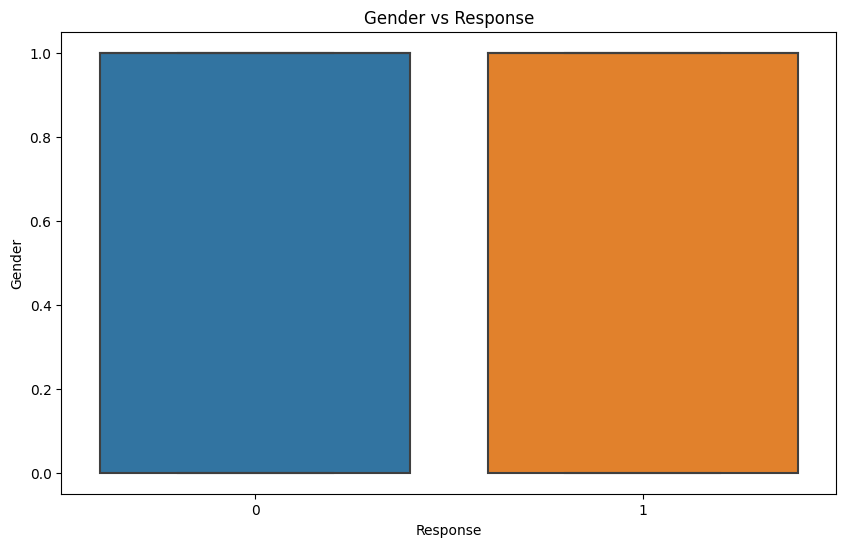

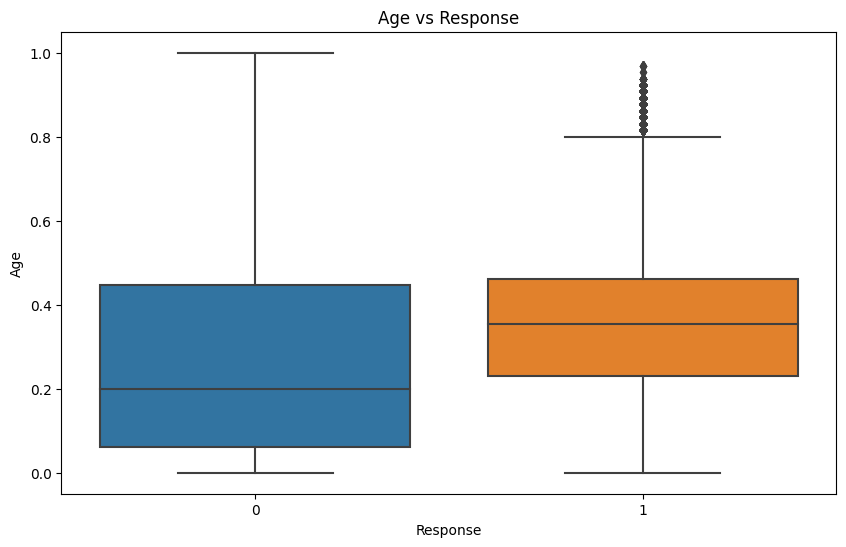

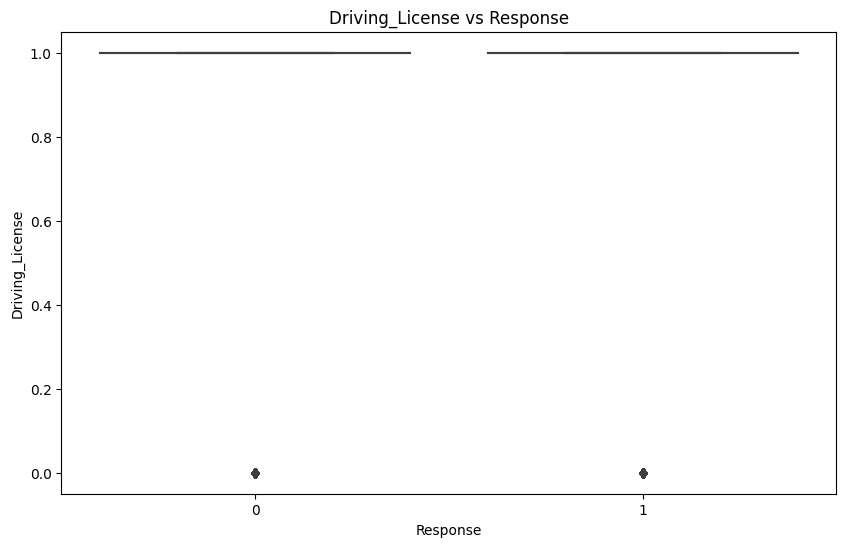

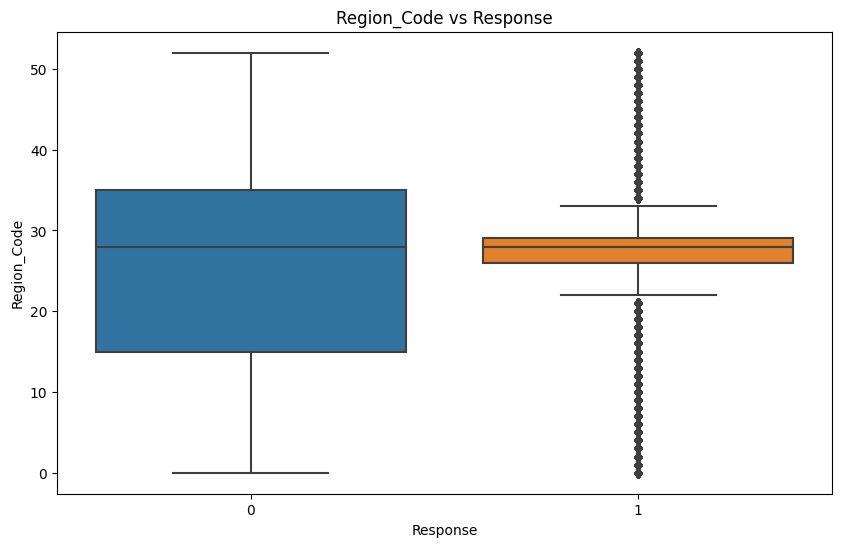

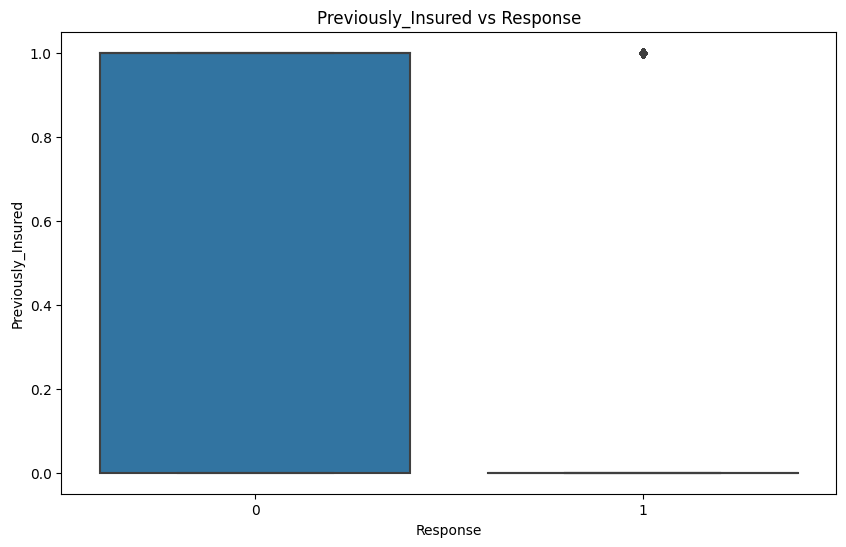

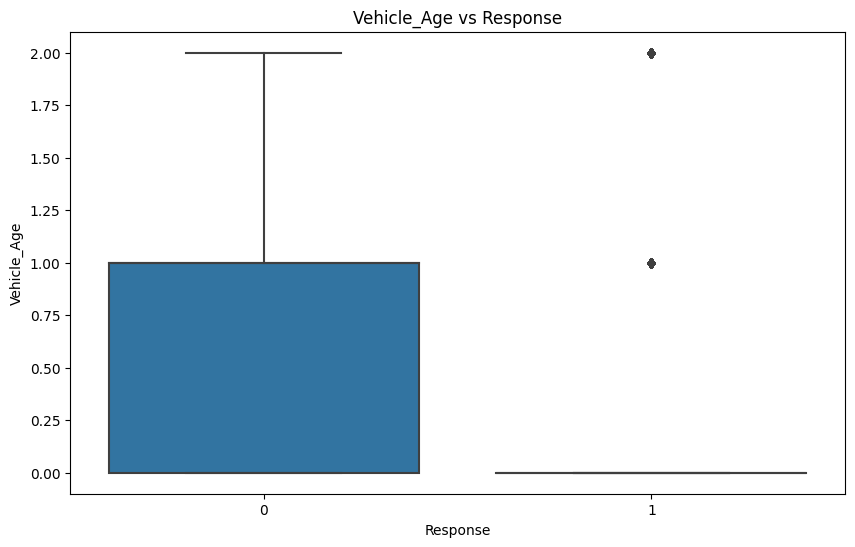

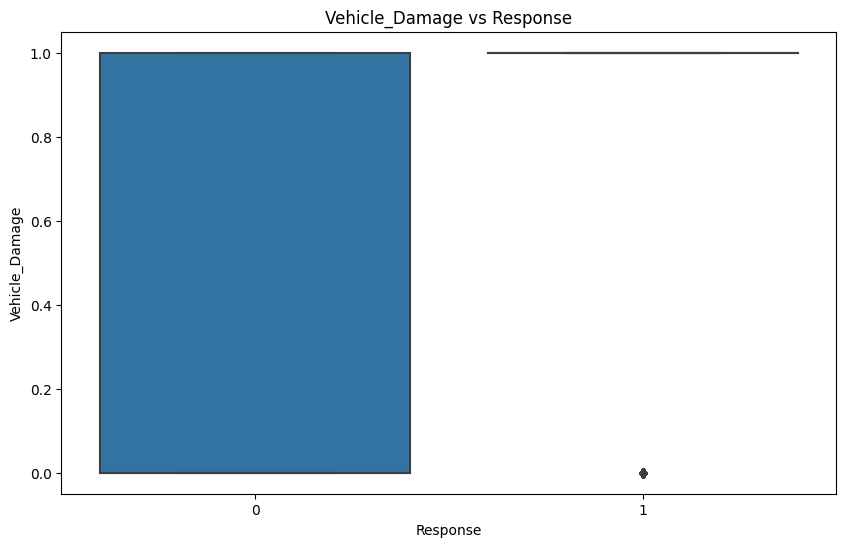

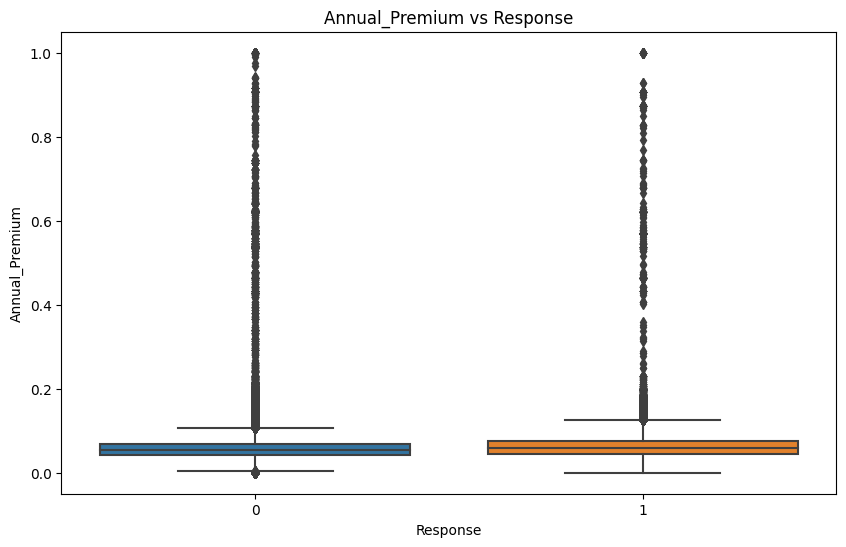

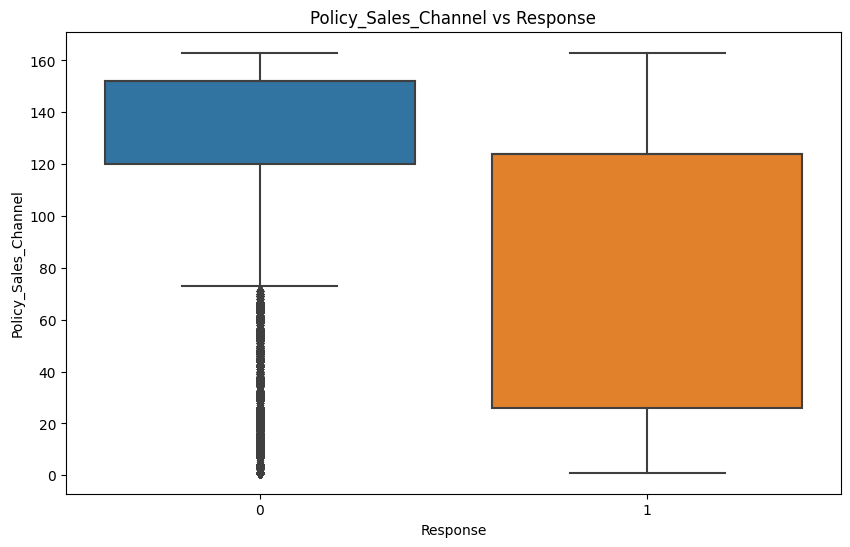

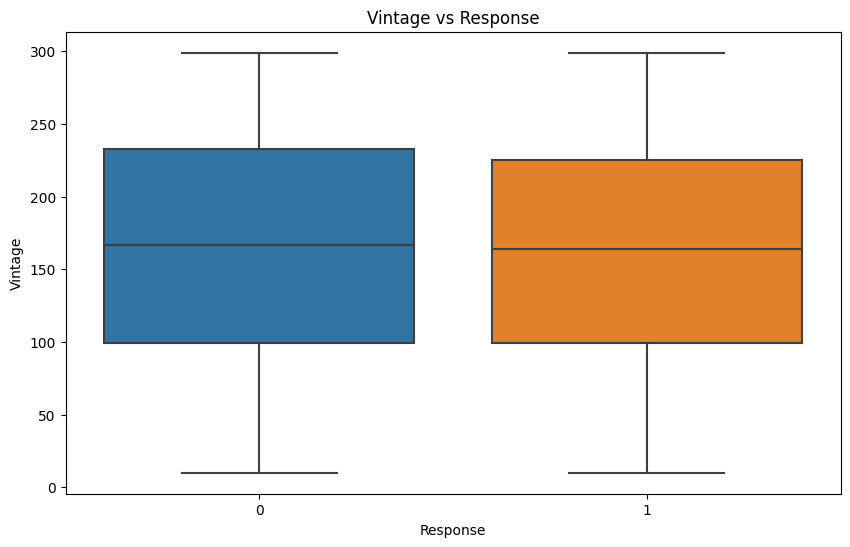

In [23]:
for feature in train.columns:
    if feature != 'Response' and feature != 'id':
        plt.figure(figsize = (10, 6))
        sns.boxplot(x = train['Response'], y = train[feature])
        plt.title(f'{feature} vs Response')
        plt.show()

## Cross-Table Analysis
Categorical Variables 사이 관계를 파악하기 위해 Cross-Table, Bar를 생성한다. <br>

**Cross-Table Analysis Purpose** <br>
Categrical Variables들이 Response와 어떻게 상호작용 하는지 파악한다. <br>
이를 통해 각 Variables의 중요성, 상관성을 확인할 수 있다. <br>
Cross-Table과 Bar Graph를 사용해 각 Categorical Variables가 Target Variables에 대해 어떻게 분포되는지 Visualize 할 수 있다. <br>
특정 범주에서 Target Variables의 비율이 높거나 낮은 Pattern을 발견할 수 있고 이는 Modeling 과정에서 중요한 특징을 제공할 수 있다. <br>
비정상적으로 높거나 낮은 값을 가진 범주를 확인하고 이상치를 탐지해 Data Pre-Processing에 활용할 수 있다. 

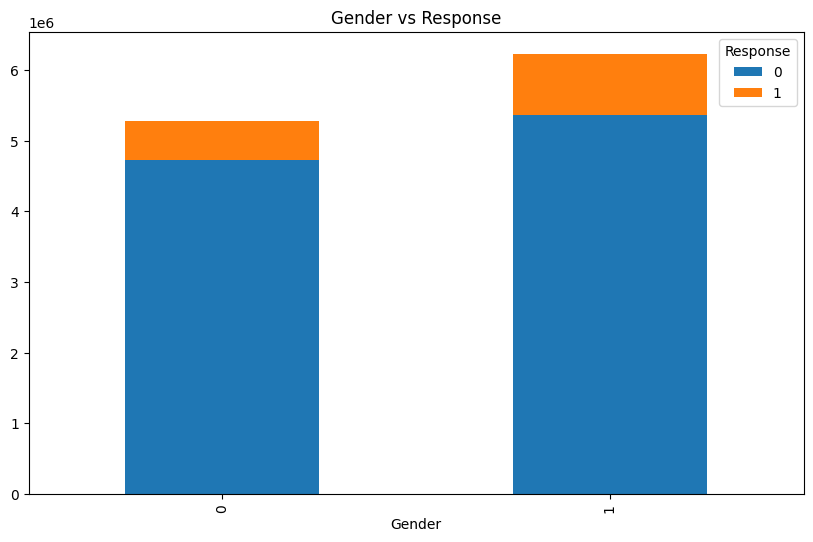

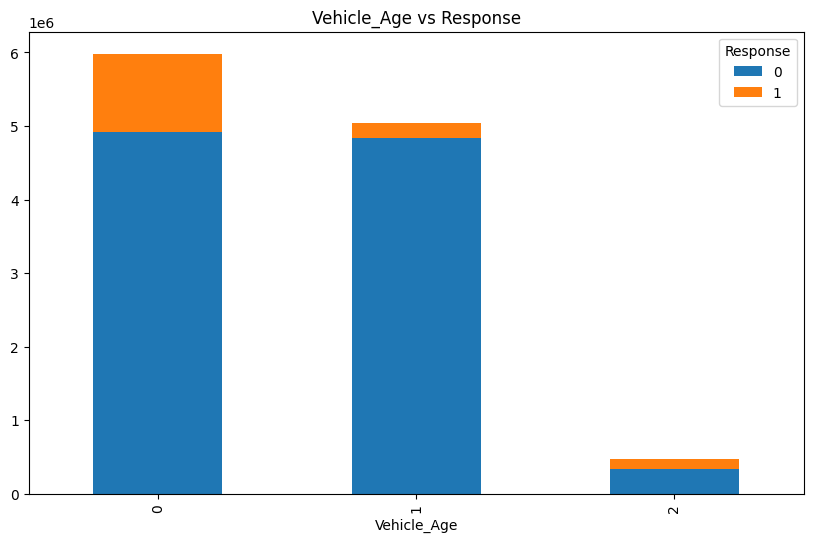

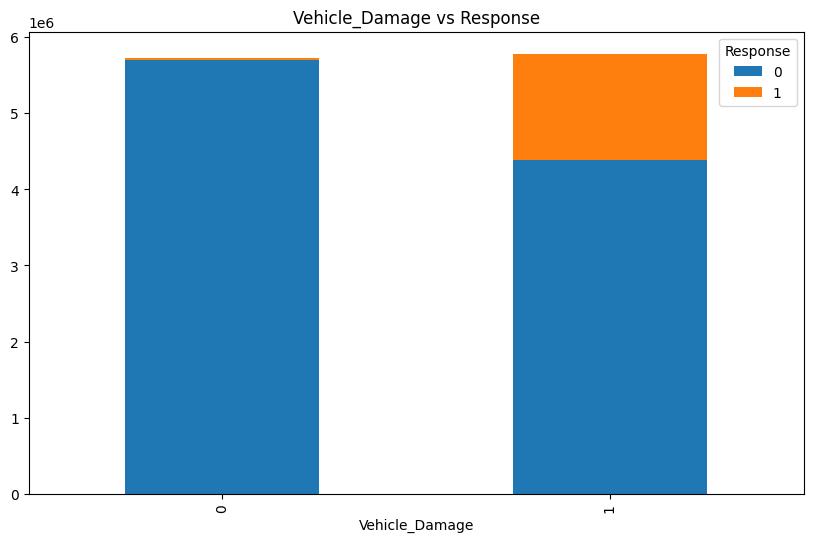

In [24]:
# Categorical Variables 
for feature in categorical_features:
    cross_tab = pd.crosstab(train[feature], train['Response'])
    cross_tab.plot(kind = 'bar', stacked = True, figsize = (10, 6))
    plt.title(f'{feature} vs Response')
    plt.show()

## Train Data, Test Data Distribution Comparison
Train Data와 Test Data 중 Age, Annual_Premium, Vintage Variables의 분포를 Histogram으로 Visualize 해 비교한다. 

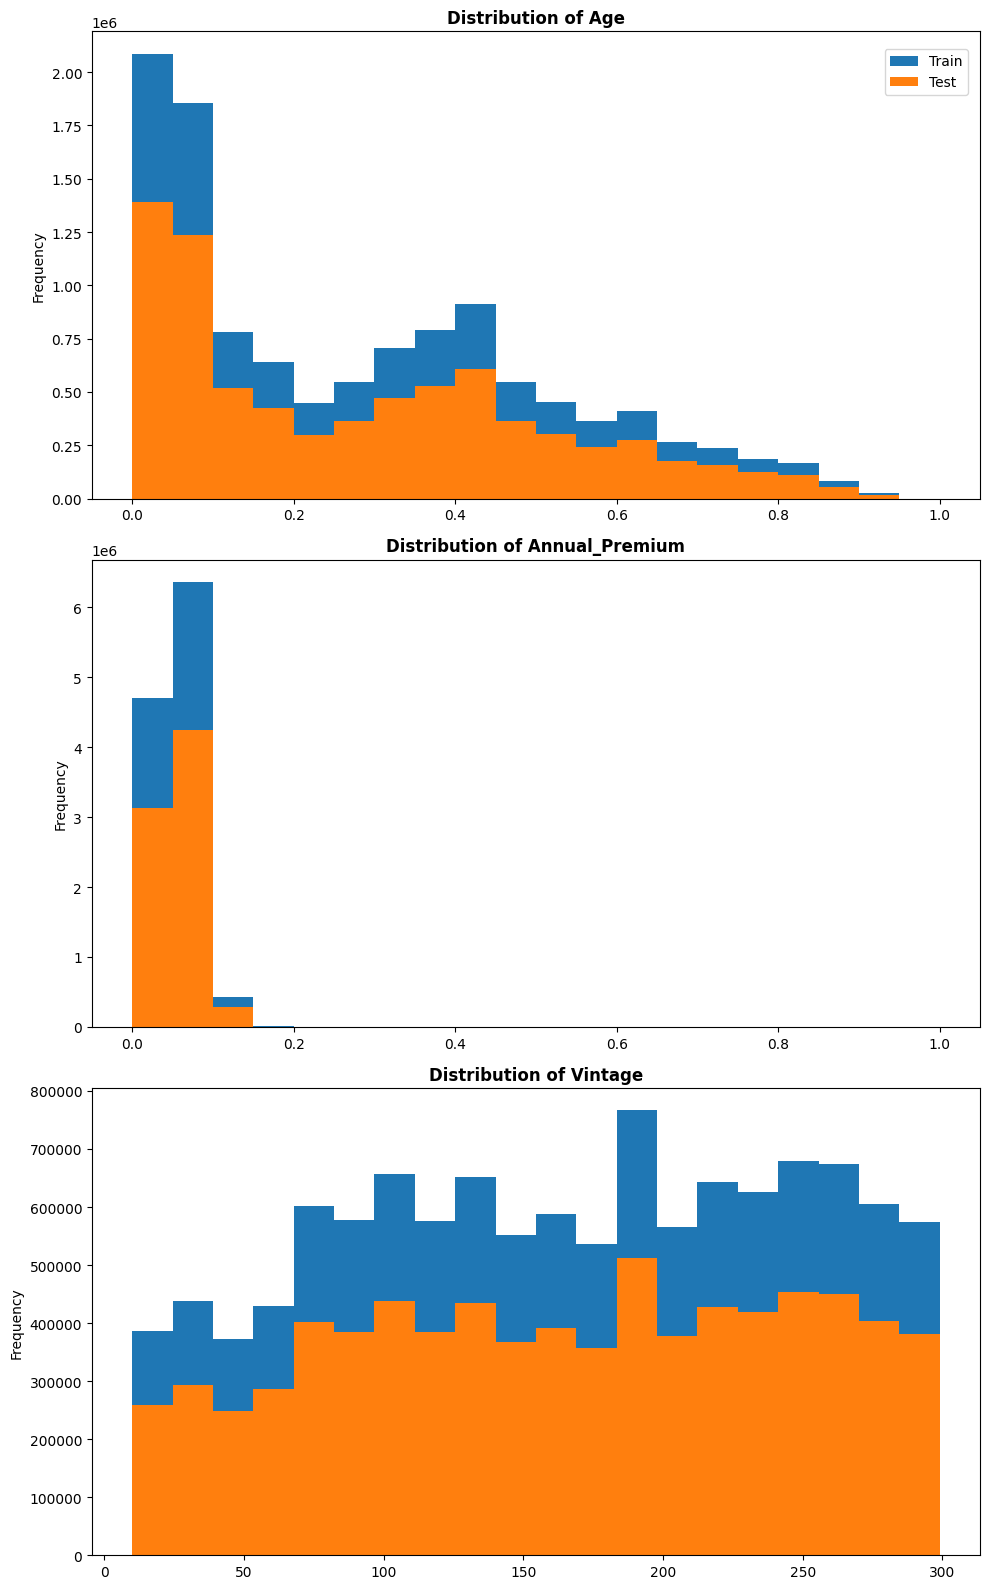

In [25]:
# Numerical Variables 
cat_vars = ['Age', 'Annual_Premium', 'Vintage']
fig, axis = plt.subplots(3,1, figsize = (10, 16))

for ax, cat_var in enumerate(cat_vars):
    # Plot Training Histogram 
    axis[ax] = train[cat_var].plot.hist(ax = axis[ax], bins = 20)
    # Plot testing histogram
    axis[ax] = test[cat_var].plot.hist(ax = axis[ax], bins = 20)
    # Set title
    _ = axis[ax].set_title(f'Distribution of {cat_var}', weight = 'bold')

# Set Legend Labels
fig.legend(['Train', 'Test'], bbox_to_anchor=(0.98, 0.97))
fig.set_tight_layout(True)

## Visualize the Distribution of Binary Categorical Variables on a Bar Graph
Binary Categorical Variables들의 분포를 Bar Graph로 Visualize 해 Train Data와 Test Data를 비교한다. 

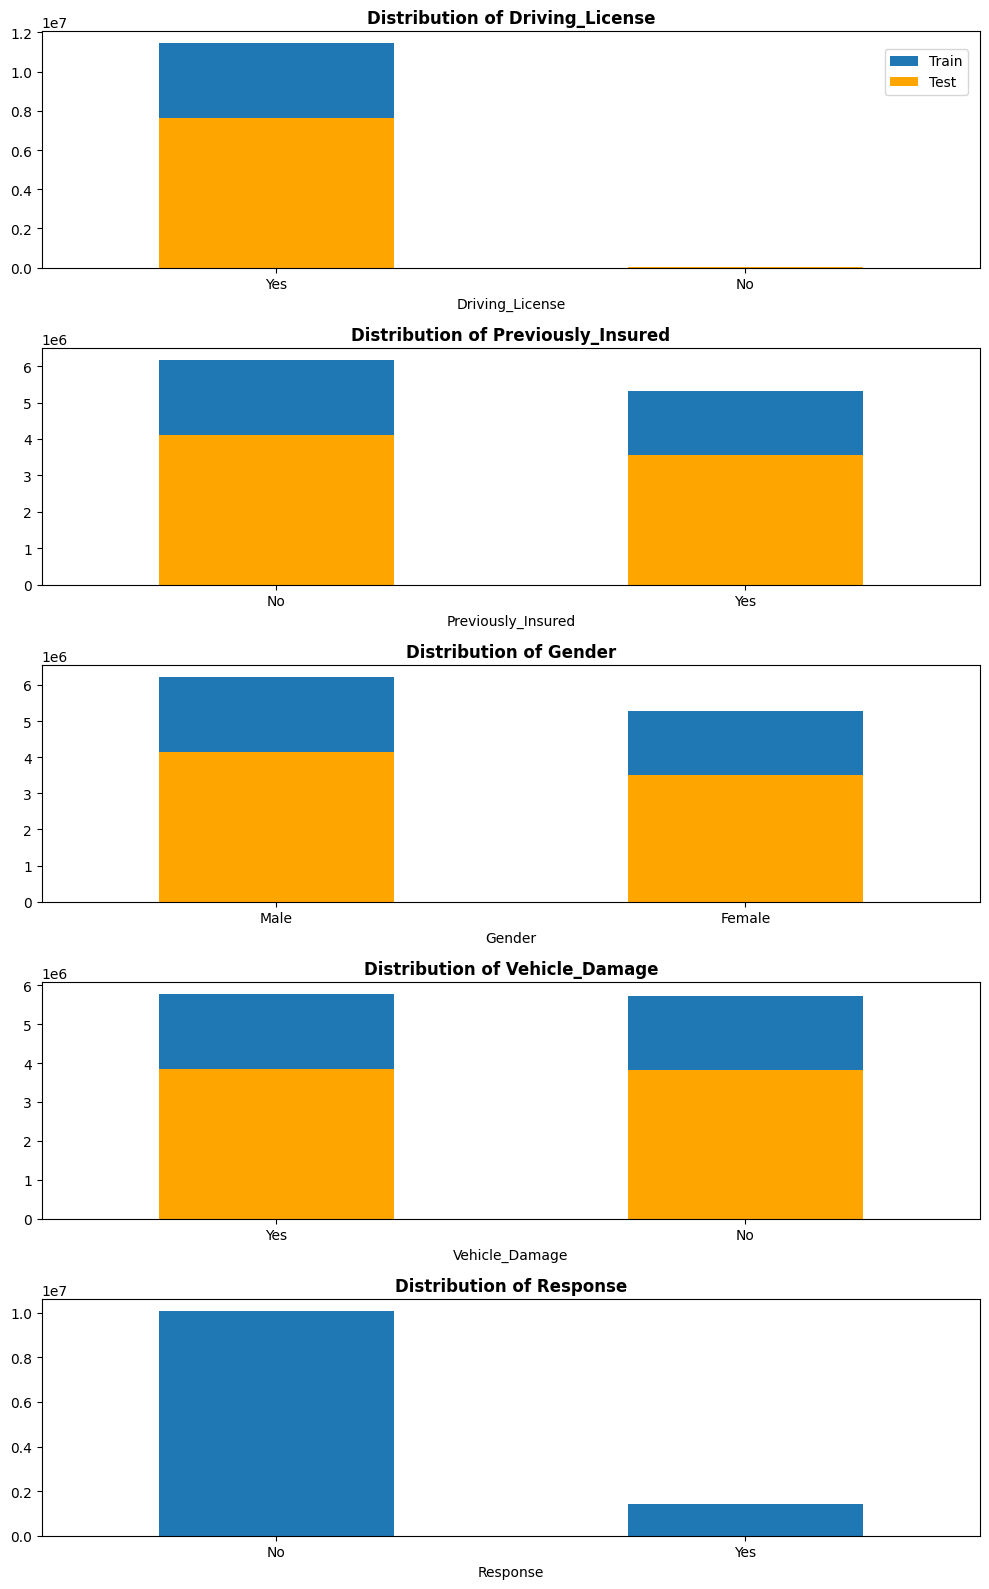

In [26]:
# Binary Categorical Features
bar_vars = ['Driving_License', 'Previously_Insured', 'Gender', 'Vehicle_Damage', 'Response']
fig, axis = plt.subplots(5,1, figsize = (10, 16))

for ax, var in enumerate(bar_vars):
    # Find value counts and barplot
    ct_train = train[var].value_counts()
    axis[ax] = ct_train.plot.bar(ax = axis[ax])
    
    # Set Title
    axis[ax].set_title(f'Distribution of {var}', weight = 'bold')
    
    # Label x Ticks for Response
    axis[ax].set_xticks([0, 1], ['No', 'Yes'], rotation = 'horizontal')
    
    if var not in 'Response':
        # Find Response Value Counts
        ct_test = test[var].value_counts()
        axis[ax] = ct_test.plot.bar(ax = axis[ax], color = 'orange')
        
        # Pick x Tick Labels
        if var in 'Gender':
            axis[ax].set_xticks([0, 1], ['Male', 'Female'], rotation = 'horizontal')
        elif var in 'Previously_Insured': 
            axis[ax].set_xticks([0, 1], ['No', 'Yes'], rotation = 'horizontal')
        else:
            axis[ax].set_xticks([0, 1], ['Yes', 'No'], rotation = 'horizontal')

fig.legend(['Train', 'Test'], bbox_to_anchor = (0.98, 0.97))
fig.tight_layout()

## Visualize the Top 10 Frequencies of a Particular Variable as a Bar Graph
Policy_Sales_Channel, Region_Code Variables의 상위 10개 값의 빈도를 Bar Graph로 Visualize해 Train Data와 Test Data를 비교한다. 

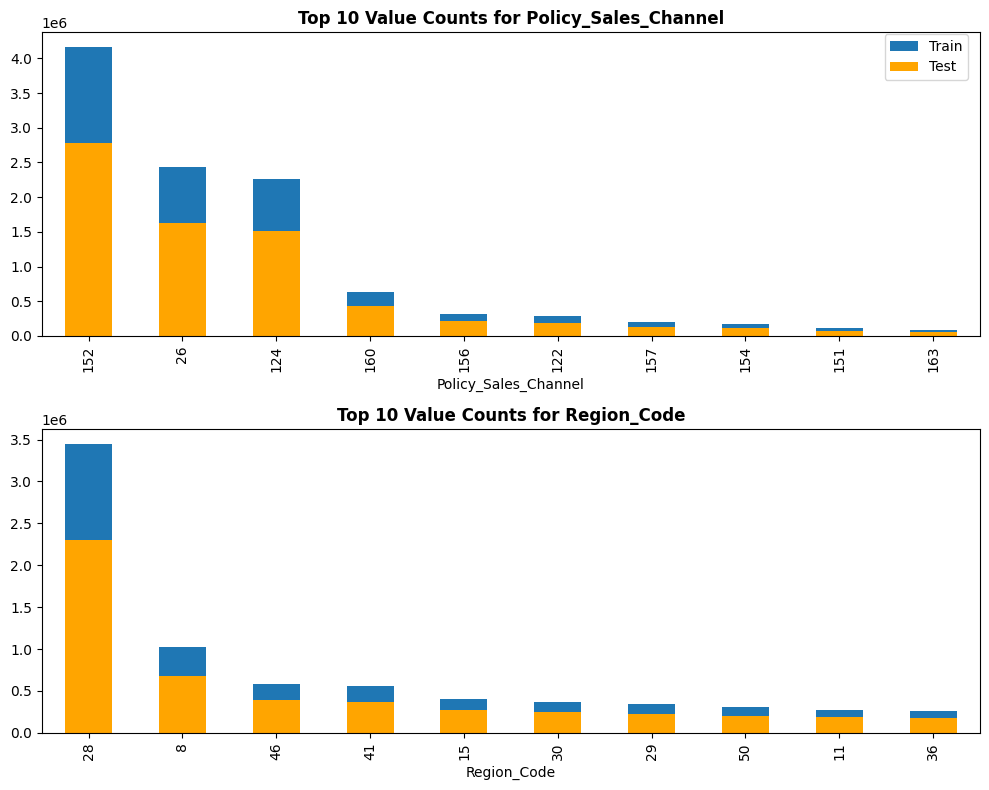

In [27]:
# Many Categories Cat Features
long_cat = ['Policy_Sales_Channel', 'Region_Code']
fig, axis = plt.subplots(2, 1, figsize = (10, 8))

for ax, var in enumerate(long_cat):
    # Top 10 by Count in Training Set
    ct_train = (train[var]
                     .astype('int16')
                     .value_counts()
                     .sort_values(ascending = False)
                     .iloc[:10])

    # Top 10 by Count in Testing Set
    ct_test = (test[var]
                   .astype('int16')
                   .value_counts()
                   .sort_values(ascending = False)
                   .iloc[:10])
    
    # Bar Plots for Train and Test Sets
    axis[ax] = ct_train.plot.bar(ax = axis[ax])
    axis[ax] = ct_test.plot.bar(ax = axis[ax], color = 'orange')
    # Set title
    axis[ax].set_title(f'Top 10 Value Counts for {var}', weight = 'bold')

fig.legend(['Train', 'Test'], bbox_to_anchor = (0.98, 0.96))
fig.tight_layout()
plt.show()

## Violin Plot
Annual_Premium Variables를 Visualize 하기 위해 Violin Plot을 사용한다. <br>
Visualize를 통해 Train Data와 Test Data의 Annual_Premium 분포를 비교한다. <br>
$100,000 이하인 Data만 사용해 이상치를 제거하고 분포를 쉽게 Visualize 할 수 있다. 

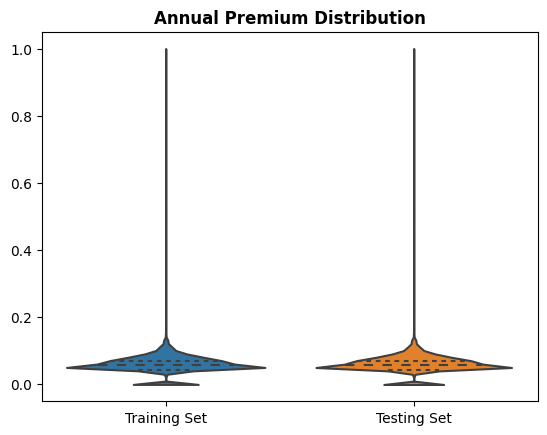

In [28]:
# Combine Train and Test below $100,000 (Removing Outliers for Easy Visulization of Distribution)
annual_premium = [
    train.Annual_Premium[train.Annual_Premium < 100_000].tolist(),
    test.Annual_Premium[test.Annual_Premium < 100_000].tolist()
]

fig = plt.figure()

# Violin Plot, Set Title and x Labels
sns.violinplot(data = annual_premium, inner = 'quart')
plt.title('Annual Premium Distribution', weight = 'bold')
plt.xticks(ticks = [0,1], labels = ['Training Set', 'Testing Set'])

plt.show()

## Hexbin Plot
Age, Annual_Premium Variables의 관계를 Visualize 하기 위해 Hexbin Plot을 사용해 Train Data와 Test Data를 비교한다. <br>
Hexbin Plot은 2차원 Histogram으로 Data의 밀도를 육각형으로 Visualize하여 Variables 사이 관계를 쉽게 확인할 수 있도록 한다. <br>
$80,000 이하의 Annual_Premium 값만 사용해 이상치를 제거한 후 Visualize 한다. 

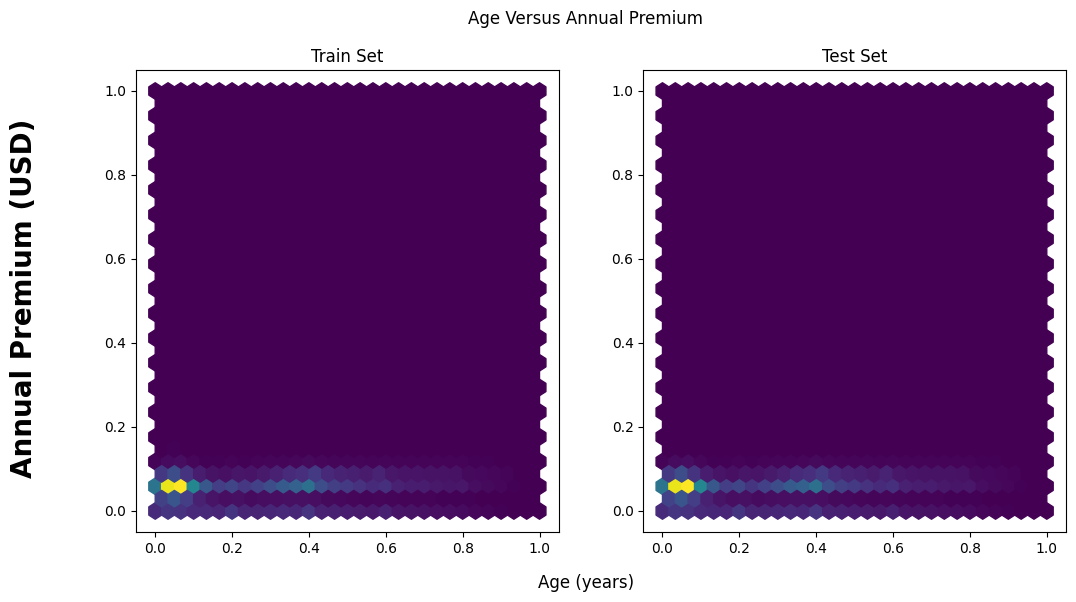

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Filter data for under $80,000 for easy visulization with removed outliers
filtered_train = train[train.Annual_Premium < 80_000]
filtered_test = test[test.Annual_Premium < 80_000]

# Hexbin Plot for Training Set
ax1.hexbin(data = filtered_train, x = 'Age', y = 'Annual_Premium', gridsize = 30)
ax1.set_title('Train Set')

# Hexbin Plot for Testing Set
ax2.hexbin(data = filtered_test, x = 'Age', y = 'Annual_Premium', gridsize = 30)
ax2.set_title('Test Set')

# Set Main x Label, y Label, and Title
fig.supxlabel('Age (years)')
fig.supylabel('Annual Premium (USD)', weight = 'bold', size = 20)
fig.suptitle('Age Versus Annual Premium')

plt.show()

## Pair Plot
Train Data의 일부 Variables를 사용해 Pair Plot을 만든다. <br>
Pair Plot은 여러 Variabls 쌍 간의 관계를 Visualize 하는데 사용하고 Data 분포와 Variables 사이 상관 관계를 쉽게 파악할 수 있도록 한다. <br>
Response Variabls에 따라 Data Point를 색상으로 구분, 각 Variabls 쌍 간의 관계를 Visualize 한다. 

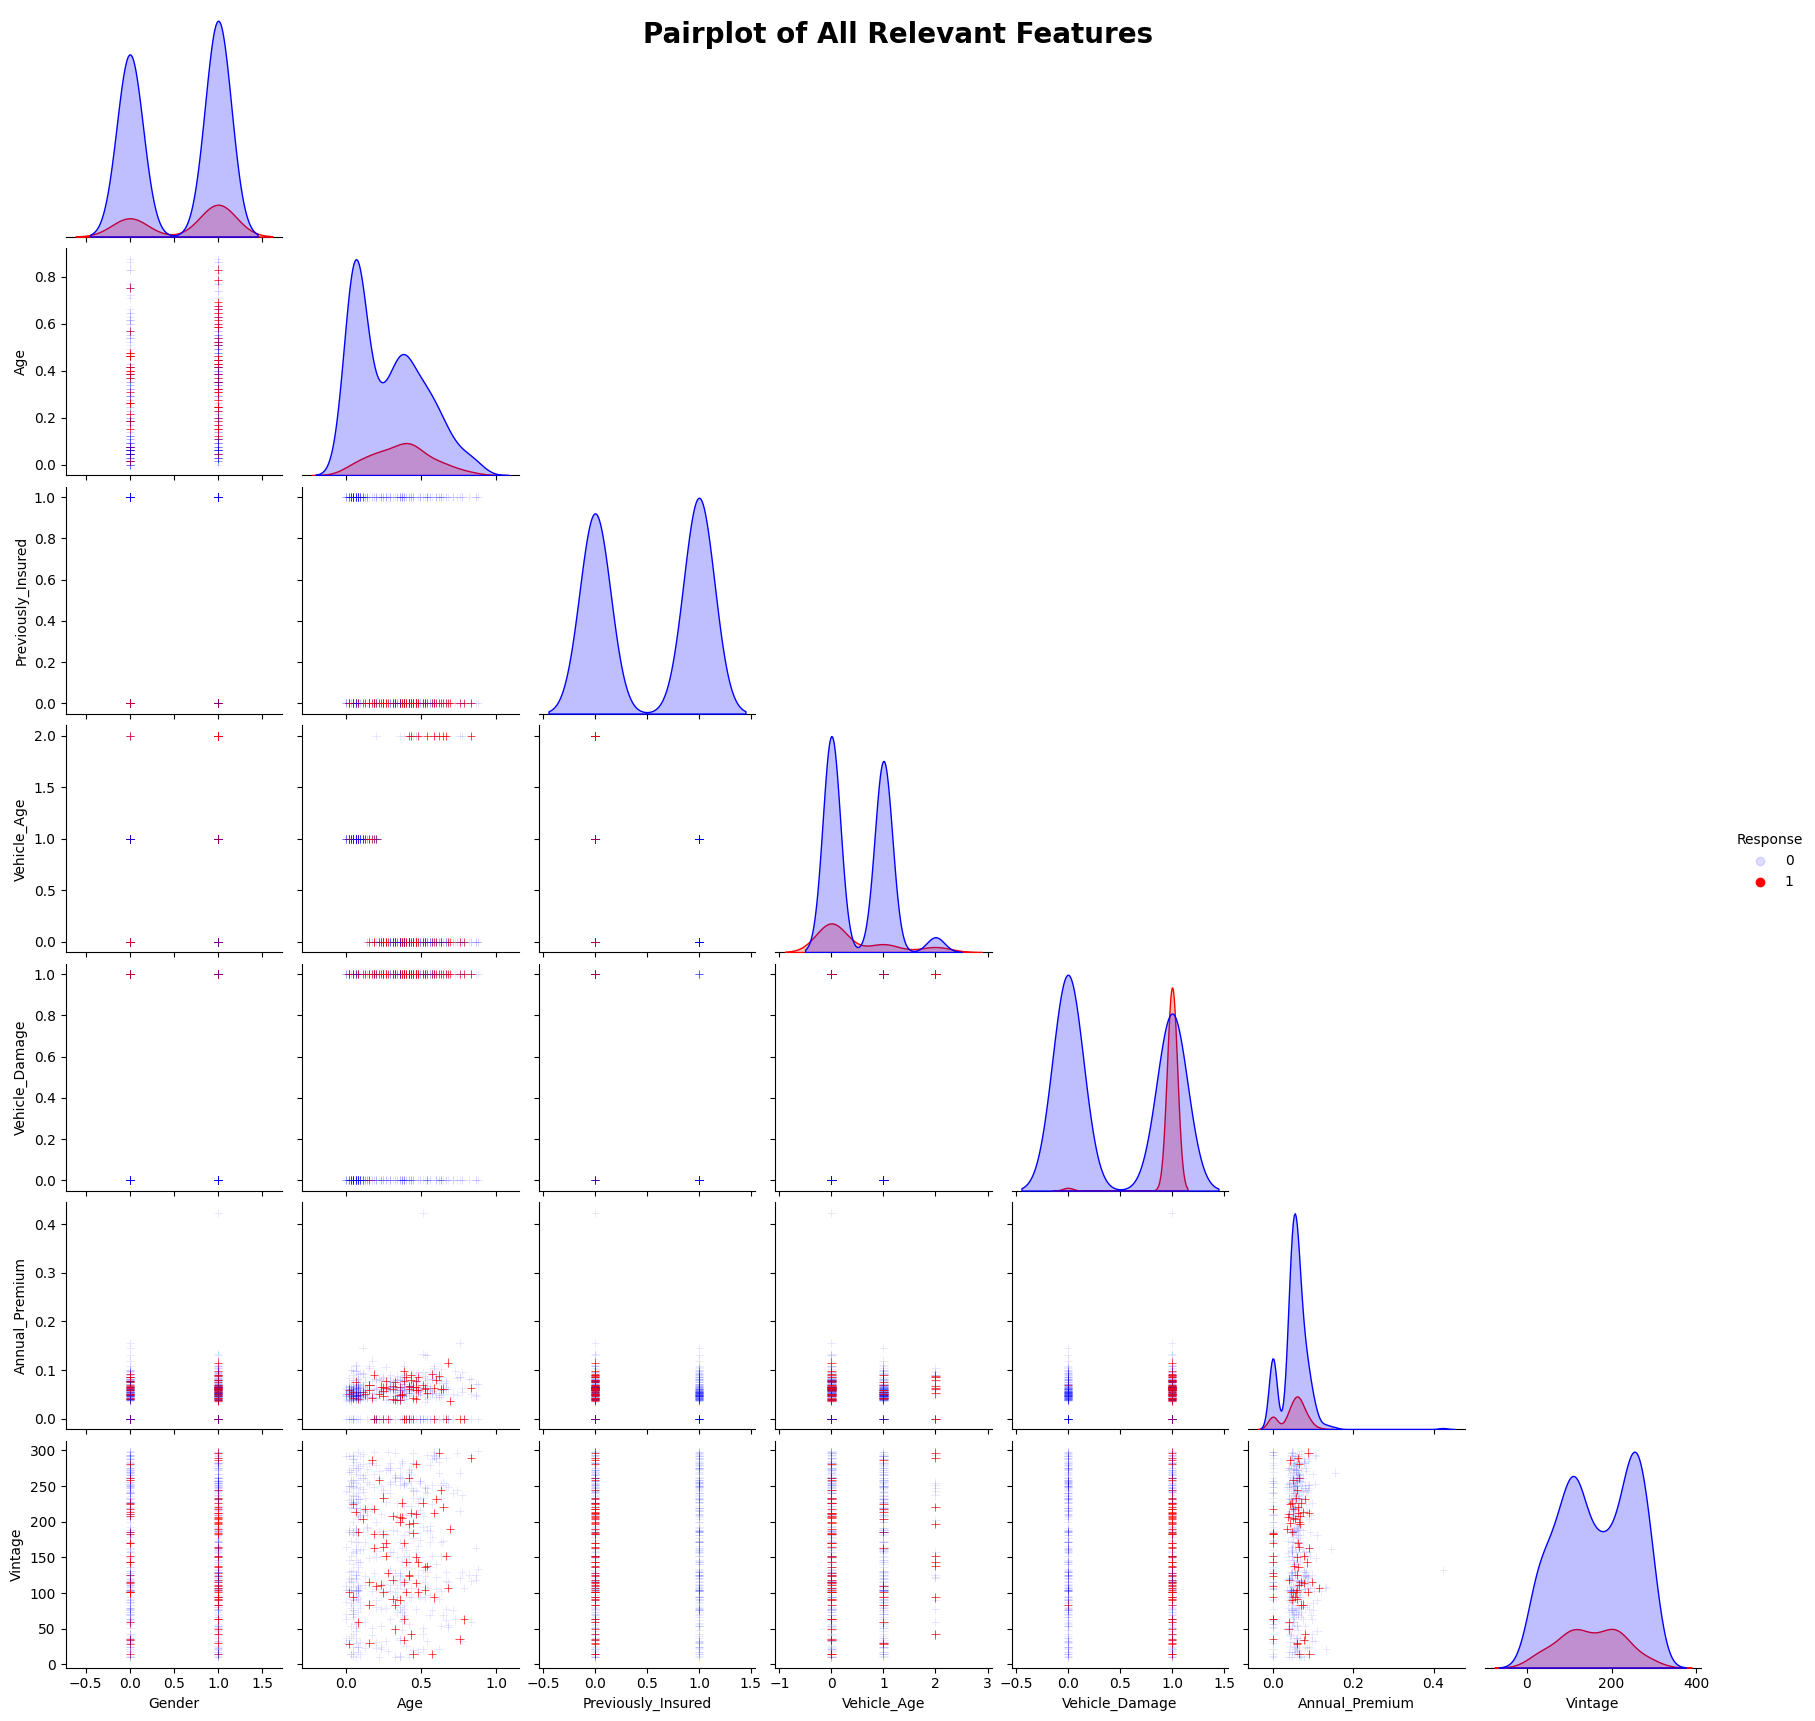

In [30]:
# Pair Plot (500 Sample for Quicker Plotting)
sns.pairplot(train.drop(columns = ['Driving_License', 'Policy_Sales_Channel', 'Region_Code']).sample(500),
             hue = 'Response',
             palette = {0: '#0000ff21', 1: '#ff0000'},
             corner = True,
             plot_kws = dict(marker = '+'))

# Set Title 
plt.suptitle('Pairplot of All Relevant Features', weight = 'bold', size = 20)

plt.show()

## Correlation Analysis
Featrue 간 Correlation Analysis를 Visualize 한다. <br>

**Correlation Analysis Purpose** <br>
Feature 간 상관 관계를 확인했을 때, 높은 상관 관계는 두 Variables 사이의 강한 선형 관계를 나타낸다. <br>
두 개 이상의 Feature가 서로 강하게 연관되어 있는 경우, 다중 공선성이 발생할 수 있다. <br>
이는 Model의 안정성과 해석에 문제가 생길 수 있어 상관 관계 Metrix를 통해 이를 사전에 탐지하고 처리할 수 있다. <br>
또한 상관 관계 분석은 중요한 Feature를 선택하고, 중요하지 않은 Feature를 제거하는데 도움을 준다. <br>
Model 성능을 향상시키기 위해 상관 관계가 높은 Feature를 확인할 수 있다.

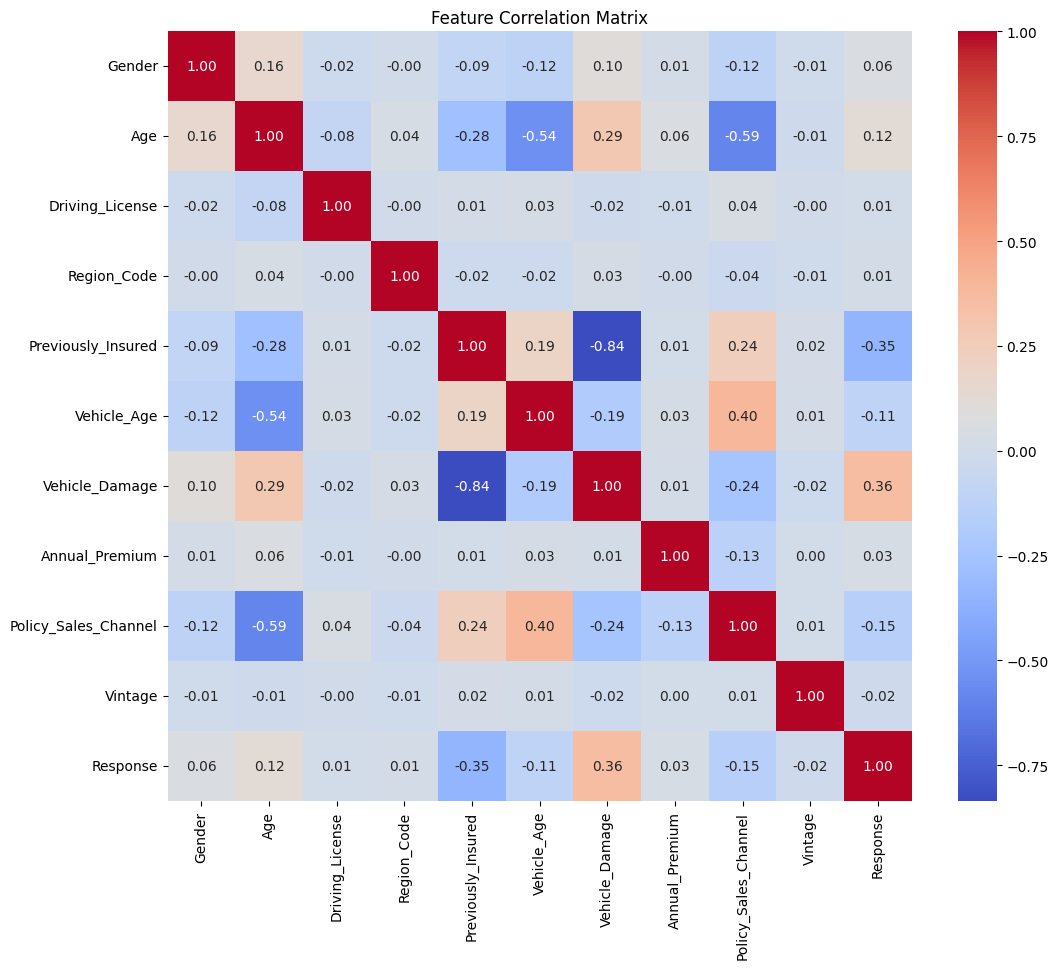

In [31]:
plt.figure(figsize = (12, 10))
correlation_matrix = train.corr() # 상관 관계 Metrix 계산 
sns.heatmap(correlation_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm') # Heatmap Visualize
plt.title('Feature Correlation Matrix')
plt.show()

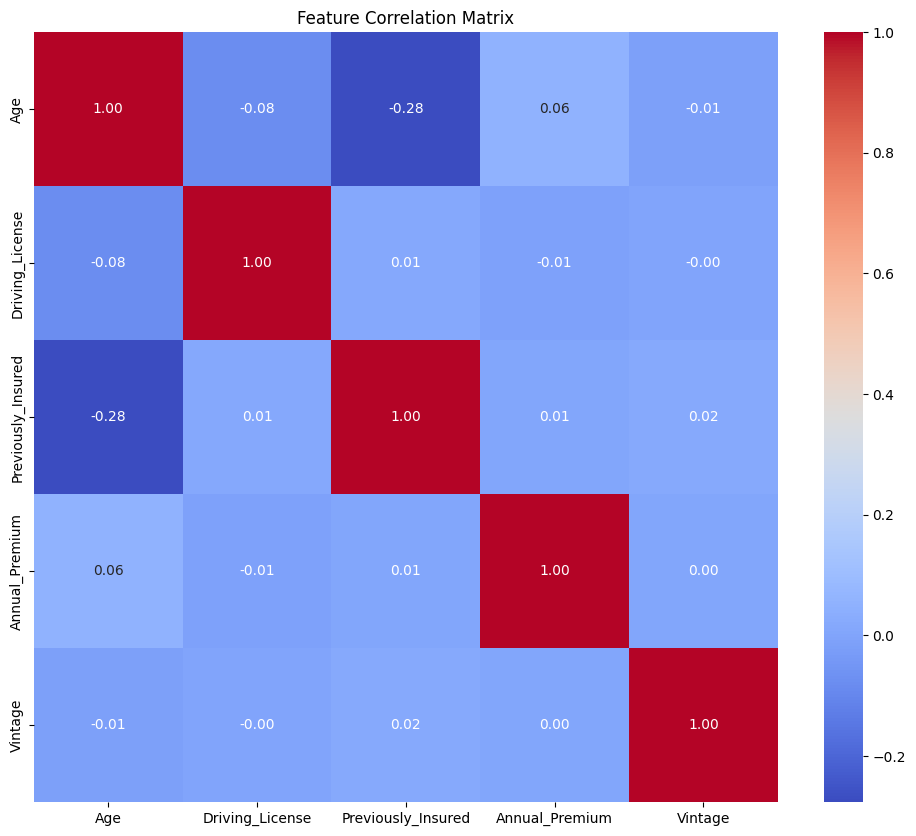

In [32]:
# Categorical Variables는 Data 분포가 선형적이지 않으므로 Numerical Variables만 분석한다. 
selected_columns = ['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Vintage']

plt.figure(figsize = (12, 10))
correlation_matrix = train[selected_columns].corr() # 상관 관계 Metrix 계산 
sns.heatmap(correlation_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm') # Heatmap Visualize
plt.title('Feature Correlation Matrix')
plt.show()

## Calculate Mutual Information Scores
각 Variables와 Target Variables Response 사이의 상호 정보를 계산해 Variables 중요도를 평가한다. <br>
Mutual Information은 두 Variables 사이 비선형 관계를 측정하는데 사용한다. 

In [33]:
# Calculate mutual information scores and show when each part is complete
scores = {}
for var in train.drop(columns = 'Response').columns:
    print(var, end = ' - ')
    scores[var] = mi_score(train[var], train.Response)
    print('✓', end = ' ')

Gender - ✓ Age - ✓ Driving_License - ✓ Region_Code - ✓ Previously_Insured - ✓ Vehicle_Age - ✓ Vehicle_Damage - ✓ Annual_Premium - ✓ Policy_Sales_Channel - ✓ Vintage - ✓ 

## Mutual Information Visualization 
각 Variables와 Target Variables Response 사이 상호 정보인 Mutual Information 점수를 Visualize 한다. <br>
상호 점수를 barplot으로 표시해 Variables 중요도를 표시한다. 

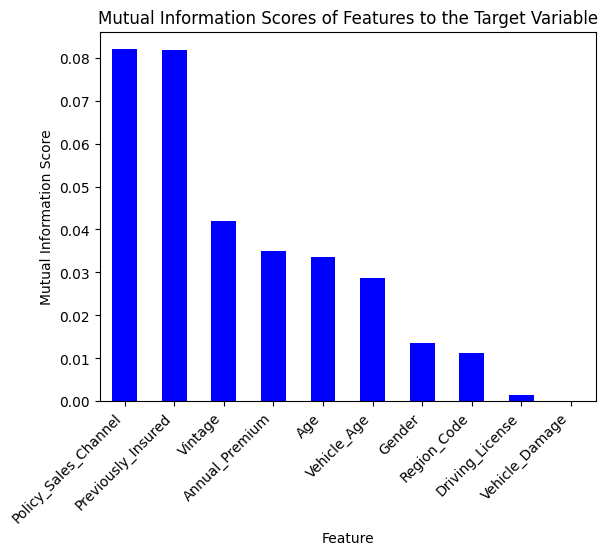

In [34]:
# Convert MI scores and feature names to a Pandas Data Frame, and sort it 
score_vals = pd.DataFrame(scores.items()).sort_values(by = 1, ascending = False)

# Create and format a bar plot showing MI scores for each predictor feature to the taget feature
score_vals.plot.bar(color = 'blue')
plt.xticks(ticks = list(score_vals.index), labels = train.columns[:-1], rotation = 45, ha = 'right')
plt.title('Mutual Information Scores of Features to the Target Variable')
plt.xlabel('Feature')
plt.ylabel('Mutual Information Score')

# Remove the Legend
plt.legend().remove()

# Modeling

## Data Split and Pre-Processing

In [35]:
# Data 분할 및 Pre-Processing
X = train.drop(columns = 'Response')
y = train.Response

## Time Transfer Function
초를 분, 초로 변환하는 Function으로 주어진 초를 60으로 나눠 분을 계산 후 나머지 초를 계산한다. 

In [36]:
def convert_to_minutes_seconds(seconds):
    '''
    This function converts seconds to minutes and seconds.
    
    Args: 
        seconds - (int) seconds returned from time library.
        
    Outputs: 
        minutes - (int) minutes.
        rem_seconds - (float) seconds rounded to two decimal places.
    '''
    minutes = int(seconds // 60)
    rem_seconds = seconds % 60 
    
    return minutes, round(rem_seconds, 2)

## K-Fold
K-Fold 교차 검증은 Data를 K개의 Fold로 나누어 각각의 Fold에 대해 Training과 Test를 반복하는 방식이다. <br>
이를 통해 Model의 성능을 보다 신뢰성있게 평가할 수 있고, 각 Fold 별로 Model을 Training 하고 Evaluation Matrics(성능 지표)을 계산한 후, 모든 Fold의 Average Evaluation Matrics(평균 성능 지표)를 최종 평가 결과로 사용한다. 

### Data Split
전체 Data를 K개의 Fold로 나눈다. StratifiedKFold를 사용해 각 Fold가 Target Variables의 Class를 동일하게 유지하도록 한다.

### Fold Training and Test
**Fold** <br>
해당 Fold를 Test Data로 사용하고, 나머지 Fold를 Training Data로 사용한다. <br>
Model을 Training Data로 Training 시킨 후 Test Data로 성능을 평가한다. <br> 
각 Fold 별 Evaluation Matrics(정확도, 정밀도, 재현율, F1 Score, ROC AUC)를 계산하고 저장한다. <br>

**Evaluation Matrics** <br>
Accuracy (정확도) : 올바르게 예측된 Sample의 비율 <br>
Precision (정밀도) : 긍정 Class로 예측한 Sample 중 실제 긍정 Class인 Sample의 비율 <br>
Recall (재현율) : 실제 긍정 Class Sample 중 올바르게 긍정 Class로 예측한 Sample의 비율 <br>
F1 Score : 정밀도와 재현율의 조화 평균 <br>
ROC AUC : Receiver Operating Characteristic 곡선 아래 면적 

## Logistic Regression Model 
Logistic Regression은 Linear Model 중 하나로 Binary Classification을 해결할 떄 자주 사용한다. <br>
기본 Dataset과 Sampling 기법 중 하나인 SMOTE를 사용한 Dataset에서 Logistic Regression Model을 Training 하고 Test 한다. <br>

Model을 Test하고 Evaluation 하기 위해, 주어진 Model을 사용해 Data를 Trainig하고 여러 Evaluation Matrics를 계산해 평균을 구한다. <br>
또한 각 Fold 별로 소요된 시간을 측정해 출력한다. 

In [37]:
def fit_model(X, y, model_type, n_splits = 5, random_state = 42):
    '''
    This function takes in the target and predictor features, as well as the model type and tests them using
    5 (default) number of K-Fold splits.
    
    Args:
        X - (DataFrame) predictor features.
        y - (DataFrame) target variable.
        model_type - (str) the type of model to use.
        n_splits=5 - (int) optional number of K-Fold splits to run.
        random_state=42 - (int) the random state for the K-Fold splits.
        
    Outputs:
        (dict) containing the accuracy, precision, recall, F1, and ROC AUC metrics (averaged of all folds).
    ''' 
    # Setting K-Fold
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    
    # Initialize Evaluation Metrics
    accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores = [], [], [], [], []
    total_time_list = []

    # K-Fold Loop
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        start_time = time.time()
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = globals()[model_type]()
        
        model.fit(X_train, y_train)
        print(f'Fold {fold + 1}: Fit - ✓', end = ' ')
        y_pred = model.predict(X_test)
        print(f'Predicted - ✓', end = ' ')
        
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        
        fold_time = time.time() - start_time
        total_time_list.append(fold_time)
        minutes, seconds = convert_to_minutes_seconds(fold_time)
        print(f'Scored - ✓\tTime: {minutes} minutes {seconds} seconds')

    # Average Evaluation Metrics
    average_metrics = {
        "accuracy": np.mean(accuracy_scores),
        "precision": np.mean(precision_scores),
        "recall": np.mean(recall_scores),
        "f1": np.mean(f1_scores),
        "roc_auc": np.mean(roc_auc_scores)
    }
    
    # Calculate Time, Print
    total_time = sum(total_time_list)
    minutes, seconds = convert_to_minutes_seconds(total_time)
    print(f'Total Time: {minutes} minutes {seconds} seconds')
    
    return average_metrics

### Sampling and Model Test Function
SMOTE, RandomUnder Sampler를 적용 Model을 평가한다. 

In [38]:
def evaluate_model_with_sampling(X, y, model_type, sampler = None, n_splits = 5):
    '''
    This function evaluates the model with the given sampling method.
    
    Args:
        X - (DataFrame) predictor features.
        y - (DataFrame) target variable.
        model_type - (str) the type of model to use.
        sampler - (object) the sampling method to use (default: None).
        n_splits=5 - (int) optional number of K-Fold splits to run.
        
    Outputs:
        (dict) containing the accuracy, precision, recall, F1, and ROC AUC metrics (averaged of all folds).
    '''
    if sampler:
        X, y = sampler.fit_resample(X, y)
    
    return fit_model(X, y, model_type, n_splits = n_splits)

## Basic Logistic Regression Model Training, Testing
fit_model Function을 사용해 Logistic Regression Model을 기본 Dataset에서 Trainnig하고 Test 한다. <br>

In [39]:
# fit_model을 사용해 LogisticRegression Model을 기본 Dataset에서 Training하고 Test한다. 
# 결과로 나온 Evaluation Matrics를 아래 Variable에 저장 후 출력해 Evaluation Matrics를 확인한다. 
logisticregression_scores = fit_model(X, y, 'LogisticRegression')  
logisticregression_scores

Fold 1: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 1 minutes 12.0 seconds
Fold 2: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 1 minutes 11.88 seconds
Fold 3: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 1 minutes 12.78 seconds
Fold 4: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 1 minutes 10.45 seconds
Fold 5: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 1 minutes 10.61 seconds
Total Time: 5 minutes 57.71 seconds


{'accuracy': 0.8762418079819001,
 'precision': 0.08992955954260837,
 'recall': 0.0006805370412237358,
 'f1': 0.0013508309350141398,
 'roc_auc': 0.49985873971101513}

## SMOTE Over-Sampling and Model Testing
Synthetic Minority Over-Sampling Technique를 사용해 Data 불균형 문제를 해결한다. 

In [40]:
# fit_resample Method를 사용해 Over-Sampling 된 Dataset X_over, y_over를 생성
# fit_model Function을 사용해 Over-Sampling 된 Dataset에서 Logistic Regression Model을 Training, Testing 한다.
# 결과로 나온 Evaluation Metrics를 logisticregression_scores_over 저장 후 출력해 Evaluation Matrics를 확인한다. 
smote = SMOTE(random_state = 42)
X_over, y_over = smote.fit_resample(X, y) 
X_over.sample

logisticregression_scores_over = fit_model(X_over, y_over, 'LogisticRegression', n_splits = 3)
logisticregression_scores_over

Fold 1: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 2 minutes 11.09 seconds
Fold 2: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 2 minutes 6.12 seconds
Fold 3: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 2 minutes 9.14 seconds
Total Time: 6 minutes 26.34 seconds


{'accuracy': 0.7869416146433671,
 'precision': 0.7065386899810305,
 'recall': 0.9815853512207532,
 'f1': 0.8216552938722578,
 'roc_auc': 0.7869416146479685}

## RandomUnderSampler를 사용한 Under-Sampling Model Testing
RandomUnderSapler를 사용해 Data 불균형 문제를 해결한다. 

In [41]:
# fit_resample Method를 사용해 Under-Sampling 된 Dataset X_under, y_under를 생성
# fit_model Function을 사용해 Under-Sampling 된 Dataset에서 Logistic Regression Model을 Training, Testing 한다. 
# 결과로 나온 Evaluation Metrics를 logisticregression_scores_under 저장 후 출력해 Evaluation Matrics를 확인한다. 
rus = RandomUnderSampler(random_state = 42)
X_under, y_under = rus.fit_resample(X, y)
X_under.sample

logisticregression_scores_under = fit_model(X_under, y_under, 'LogisticRegression', n_splits = 3)
logisticregression_scores_under

Fold 1: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 0 minutes 21.84 seconds
Fold 2: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 0 minutes 21.27 seconds
Fold 3: Fit - ✓ Predicted - ✓ Scored - ✓	Time: 0 minutes 22.16 seconds
Total Time: 1 minutes 5.27 seconds


{'accuracy': 0.7872883746075914,
 'precision': 0.7068461750587763,
 'recall': 0.9817378639680291,
 'f1': 0.821916619166808,
 'roc_auc': 0.7872883747456415}

여러 개의 Sampling 방법을 사용해 Logistic Regression Model의 성능을 비교하여 Data 불균형 문제를 해결할 때 효과적인 방법을 찾을 수 있다. 

# Submission

In [42]:
# Instance of Logistic Regression Model
model = LogisticRegression()

# Fitting the model 
model.fit(X, y)

# Creating predictions
predictions = model.predict(test)

In [43]:
output = pd.DataFrame({
    'id': test.index,
    'Response': predictions
})

In [44]:
output.head()

,id,Response
0,11504798,0
1,11504799,0
2,11504800,0
3,11504801,0
4,11504802,0


In [45]:
output.to_csv('submission.csv', index = False)